<a href="http://www.stfc.ac.uk/"> <img src="../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


In [3]:
import sys
sys.path.append("../lib/")
import models
import pandas, random, math
from sklearn import metrics
import numpy 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

models.hideAnswers

# Classifier performance

There are several summary statistics that indicate the quality of a classifier. Let's generate some classifiers and compare the statistics.



## The confusion matrix

Given a problem, a classifier, and a threshold, we can work out these totals:

| Confusion Matrix | Actual +ve | Actual -ve | Totals |
| --- | --- | --- | --- |
| Predicted +ve | True +ve |False +ve| *pp*
| Predicted -ve | False -ve|True -ve|*pn*
|Totals|*ap*|*an*|*N*

There are four degrees of freedom here, which is why it is not possible to state the performance of classifier in one number. 
Here is a classification problem, and implementations of some of the performance measures that are used.


In [5]:
#let's create a random list True/False entries
y = [random.random()< (i/100) for i in range(0,100)]

# actual conditions, positive and negative
ap = sum(y) #number of True
an = len(y)-ap #number of False

# for any classifier and threshold, let tp and tn be the number of correctly called positives and negatives
def pp(tp, tn): # predicted positives
    return tp+an-tn

def pn(tp, tn): # predicted negatives
    return tn+ap-tp

# rates
def typeI(tp, tn): # false positive rate 
    return 1 - tn/an

def typeII(tp, tn): # false negative rate 
    return 1 - tp/ap

def recall(tp, tn):  # true positive rate 
    return tp / ap

def specificity(tp, tn):  # true negative rate 
    return tn / an

def precision(tp, tn): # true positive, as a fraction of predicted positive
    return tp /  pp(tp, tn)

def falseOmissionRate(tp, tn): # false negatives, as a frction of predicted negatives
    return (ap-tp) / pn(tp, tn)

def falseDiscoveryRate(tp, tn):
    return (an-tn) /  pp(tp, tn)

def negativePredictedValue(tp, tn):
    return tn / pn(tp, tn)



Let's visualise these scores.

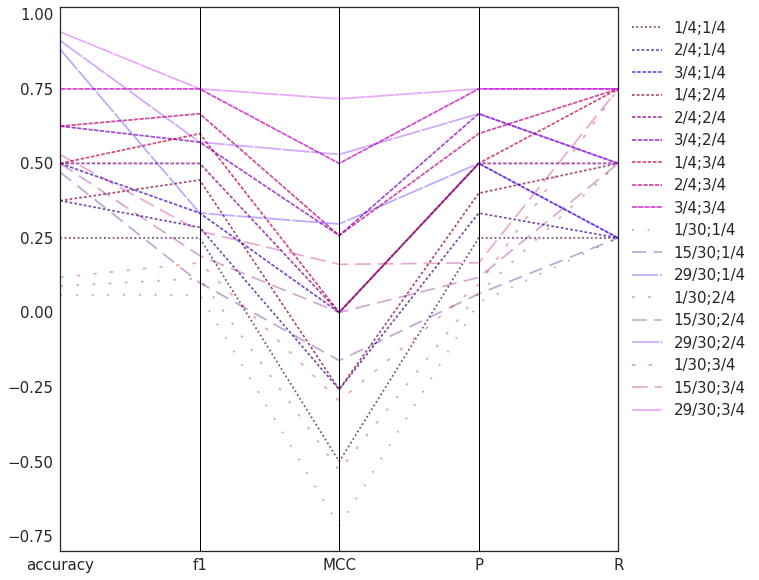

In [6]:
from pandas.plotting import parallel_coordinates
from sklearn import metrics
import matplotlib

# see http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

SCORES = {
 'accuracy':'accuracy_score', # same as 'jaccard_similarity_score', opposite of 'zero_one_loss', 'hamming loss'
 'f1':'f1_score',
 # 'fbeta_score',   needs an extra parameter
 # 'log_loss', too big
 'MCC':'matthews_corrcoef',
 'P':'precision_score',
 'R':'recall_score', 
}


def score(name, y_true, y_pred): 
    ret = {'name':name} 
    for score in list(SCORES.keys()):
        ret[score] = metrics.__dict__.get(SCORES[score])(y_true, y_pred)
    return ret

def ys(tn, an, tp, ap):
    y_true = [0]*an + [1]*ap
    y_pred = [0]*tn + [1]*(an-tn) + [1]*tp + [0]*(ap-tp)
    return [y_true, y_pred]

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
#plt.figure(figsize=())
#ax.xaxis.tick_top()

#draw 9 lines for combination of different TP/TN.
def show(ap, an):
    for tp in [1, ap//2, ap-1]: #try 3 different values for number of true positives
        for tn in [1, an//2, an-1]: #try 3 different values for number of true negatives
            data = [] #columns are label, scores (accuracy, f1, mcc, p ,r)
            data.append(score('{}/{};{}/{}'.format(tn, an, tp, ap),*ys(tn, an, tp, ap) ) )
            df = pandas.DataFrame(columns=['name']+list(SCORES.keys()), data = data) 
            color = '#{:02X}00{:02X}'.format((256*tp)//ap, (256*tn)//an) # red shows recall, blue shows precision
            dashes = [(tp+tn)/2, (ap+an-tp-tn)/4] # dashes show accuracy
            parallel_coordinates(df, 'name', alpha=math.sqrt(ap/(ap+an)), # alpha shows fraction positive
                                 color=color, dashes=dashes)
            plt.legend(bbox_to_anchor=(1,1))

#plt.xticks(rotation='vertical')
show(4,4)
show(4, 30)  


If there are few positives, then the accuracy can be high even with poor recall.

The lines in this graph cross a lot: no two statistics rank these classifiers the same way. For definitions see:
-    http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
-    http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

These are all complete classifiers: for each new x value, they predict y=False or y=True. Many models, like Naive Bayes, predict a score ranging from 0 to 1. To convert the model into a classifier, you have to choose a cutoff value. You could pick a value that optimises one of these statistics, but it is often possible to optimise an actual business goal.

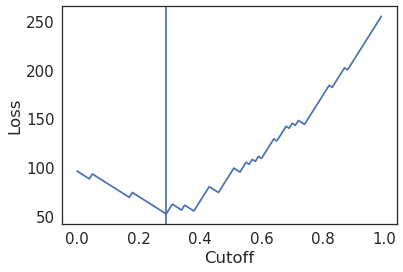

In [7]:
# actuals
y = [random.random()< (i/100) for i in range(0,100)]

# predictions
score = [ i/100 for i in range(0,100)] 

# losses for false positive, false negative
fp_loss = 2
fn_loss = 5

def get_loss(i, cutoff):
    if score[i] >= cutoff/100: # predicted positive
        if y[i]:
            return 0 # true positive
        else:
            return fp_loss
    else:
        if y[i]:
            return fn_loss
        else:
            return 0 # true negative

loss= [0]*100
for cutoff in range(0,100):
    losses = [ get_loss(i, cutoff) for i in range(0, 100) ]
    loss[cutoff] = sum(losses)
# for min cost:
cutoff = score[numpy.argmin(losses)]
    
    
plt.figure()    
plt.plot(score, loss)
plt.ylabel('Loss')
plt.xlabel('Cutoff')
plt.axvline(x=score[numpy.argmin(loss)])
plt.show()



<div class="alert alert-warning" role="alert">
<b>Exercise:</b> Using the Naive Bayes classifier we made earlier, and the losses shown below, find the optimum cutoff.

In [8]:
fp_loss = 1
fn_loss = 10
# base your answer on the code above

The graph above shows the business loss. Ideally, you will use that loss function when training the model. However, some algorithms have limits on the loss function that can be used.

## Further reading

For more information on the topics covered here:
 [Sklearn's classification metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)


[Up](../Welcome.ipynb)<br> [Back](NaiveBayes.ipynb) [Next](PrecisionRecall.ipynb)


---------------------------------------------------
Copyright STFC 2018